# Credit Card Fraud Detection
This notebook walks through building a fraud detection model using Kaggle's credit card dataset.

## Step 1: Load and Explore Data

In [1]:
import os
import shutil

# Move kaggle.json to ~/.kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Set permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 202M/202M [00:05<00:00, 39.3MB/s] 

Extracting files...


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1


In [4]:
import os

download_path = "/home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1"
print(os.listdir(download_path))


['fraudTrain.csv', 'fraudTest.csv']


In [1]:
import pandas as pd

base_path = "/home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1"

df_train = pd.read_csv(f"{base_path}/fraudTrain.csv")
df_test = pd.read_csv(f"{base_path}/fraudTest.csv")

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


Train shape: (1296675, 23)
Test shape: (555719, 23)


## Step 2: Preprocessing

In [2]:
import sys
sys.path.append('scripts')  # adds scripts folder to path

import importlib
import process

importlib.reload(process)
from process import preprocess

In [3]:
# Preprocess
df_train_prep = preprocess(df_train)
df_test_prep = preprocess(df_test)

X_train = df_train_prep.drop(columns=['is_fraud'])
y_train = df_train_prep['is_fraud']

X_test = df_test_prep.drop(columns=['is_fraud'])
y_test = df_test_prep['is_fraud']

# Find categorical column indices
categorical_features = X_train.select_dtypes(include='int').columns  # already label encoded
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in ['merchant', 'category', 'gender', 'city', 'state', 'job']]


## Step 3: Train XGBoost Model

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Calculate the imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, 
                      use_label_encoder=False, 
                      eval_metric='logloss', 
                      random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [05:57:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[548261   5313]
 [   260   1885]]
              precision    recall  f1-score   support

           0     0.9995    0.9904    0.9949    553574
           1     0.2619    0.8788    0.4035      2145

    accuracy                         0.9900    555719
   macro avg     0.6307    0.9346    0.6992    555719
weighted avg     0.9967    0.9900    0.9927    555719



## Step 4: grid search for XGBoost with Cross-validation

In [5]:
You can skip running this cell. Check below for the best oaram already found.

SyntaxError: invalid syntax (1732178940.py, line 1)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the base model
base_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='f1',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)

# Run the random search
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_random_model = random_search.best_estimator_
print("Best parameters from RandomizedSearchCV:", random_search.best_params_)

# Evaluate the model
y_pred_random = best_random_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_random))
print(classification_report(y_test, y_pred_random))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  25.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  25.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:01:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  26.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  19.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  19.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  20.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  16.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  17.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  16.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:07:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:08:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:08:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  29.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:09:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:09:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  10.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  11.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  11.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  12.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  15.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  12.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  15.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  15.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  16.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  25.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  25.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  26.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   9.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   8.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   8.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  12.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  13.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  13.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  29.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters from RandomizedSearchCV: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
[[552933    641]
 [   664   1481]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.69      0.69      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.84      0.85    555719
weighted avg       1.00      1.00      1.00    555719



### **Best Parameters from RandomizedSearchCV**
From the RandomizedSearch we obtained the following best parameters:
```python
{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Confusion Matrix
Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.71	0.68	0.69	2145
Accuracy: 1.00
Macro Avg: Precision = 0.85, Recall = 0.84, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```

### **Light Version of the Grid Search**
We first run on Google Colab the a light version of GridSearch using the following:
```python
param_grid = {
    'n_estimators': [275, 300],  # 2 values
    'max_depth': [8, 9],         # 2 values
    'learning_rate': [0.2],      # 1 value
    'subsample': [1.0],          # 1 value
    'colsample_bytree': [0.8, 0.85]  # 2 values
}

From this version we got the following (confirming what we found with the RandomSearch):

### **Best Parameters from Light GridSearchCV**
```python
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'subsample': 1.0}
Confusion Matrix
[[552933    641]
 [   664   1481]]

 Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.70	0.69	0.69	2145
Accuracy: 1.00
Macro Avg: Precision = 0.85, Recall = 0.84, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```

In [ ]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the base model with scale_pos_weight already set
base_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)


# Define the parameter grid to search
param_grid = {
    'n_estimators': [250, 300, 350],  # Around 300
    'max_depth': [8, 9, 10],          # Around 9
    'learning_rate': [0.15, 0.2, 0.25],  # Around 0.2
    'subsample': [0.9, 1.0],          # Around 1.0
    'colsample_bytree': [0.75, 0.8, 0.85]  # Around 0.8
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,          # 3-fold cross-validation
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_grid_model = grid_search.best_estimator_
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Evaluate the model
y_pred_grid = best_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

Running the previous cell in Google Colab (to get more computing power), we got the following results:

### Results from Heavy GridSearch Run on Colab

#### Best Parameters from GridSearchCV
```python
{'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 350, 'subsample': 1.0}
Confusion Matrix
[[552977    597]
 [   654   1491]]
 Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.71	0.70	0.70	2145
Accuracy: 1.00
Macro Avg: Precision = 0.86, Recall = 0.85, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```



## Step 5: Training the model

In [10]:
# Train the final model with the best parameters
final_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.15,
    max_depth=10,
    n_estimators=350,
    subsample=1.0,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = final_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

[20:34:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[[552977    597]
 [   654   1491]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.70      0.70      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.85      0.85    555719
weighted avg       1.00      1.00      1.00    555719



## Step 6: Model Interpretation with SHAP

We already run the following two cells, hence we saved our shap_values and we can just load them back directly without computing them again. In case that does not work, decomment the following two cells and run them.

In [ ]:
# import shap

# # Create a SHAP explainer
# explainer = shap.Explainer(final_model, X_train)

# # Compute SHAP values for the test set
# shap_values = explainer(X_test)



100%|===================| 555705/555719 [271:25<00:00]         

In [ ]:
# import pickle

# # Save SHAP values
# with open("shap_values.pkl", "wb") as f:
#     pickle.dump(shap_values, f)

# # Optionally, also save the explainer
# with open("shap_explainer.pkl", "wb") as f:
#     pickle.dump(explainer, f)

In [8]:
import pickle
import shap
# Load SHAP values
with open("shap_values.pkl", "rb") as f:
    shap_values = pickle.load(f)

# Load explainer if needed
with open("shap_explainer.pkl", "rb") as f:
    explainer = pickle.load(f)


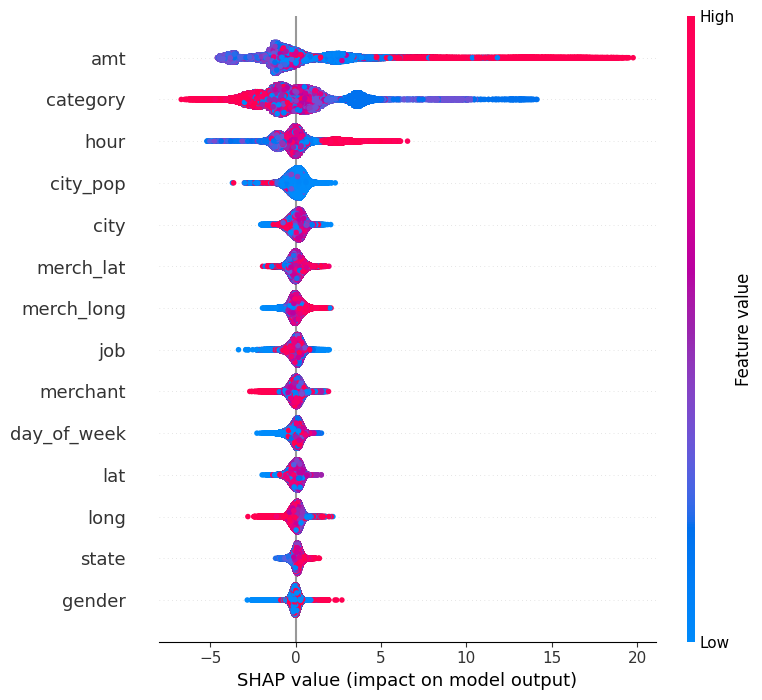

In [9]:
# Visualize feature importance
shap.summary_plot(shap_values, X_test)

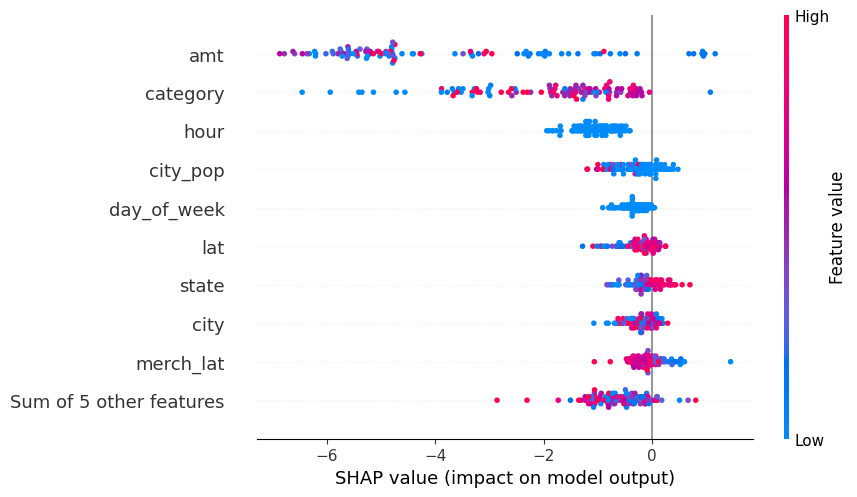

In [10]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)